In [1]:
import os
file_path = os.path.abspath(".")
execution_path = os.path.abspath(f"../../../../Binaries/Debug")

In [79]:
import os
os.chdir(file_path)
import sys
target_path = os.path.abspath(f"../../../../Binaries/Debug")
sys.path.append(target_path)
print(f"Added {target_path} to sys.path")
package_path = os.path.abspath(f"../python")
sys.path.append(package_path)
print(f"Added {package_path} to sys.path")

Added c:\Users\pengfei\WorkSpace\USTC_CG_24\Framework3D\Binaries\Debug to sys.path
Added c:\Users\pengfei\WorkSpace\USTC_CG_24\Framework3D\source\Runtime\renderer\python to sys.path


In [80]:
import glints.scratch_grid
import glints.renderer
import glints.test_utils as test_utils
import torch
import numpy as np
import pytest


In [81]:
import importlib
importlib.reload(glints.scratch_grid)

<module 'glints.scratch_grid' from 'c:\\Users\\pengfei\\WorkSpace\\USTC_CG_24\\Framework3D\\source\\Runtime\\renderer\\python\\glints\\scratch_grid.py'>

In [82]:
import numpy as np
import torch
import glints.test_utils as test_utils


def test_scratch_field():
    field = glints.scratch_grid.ScratchField(10, 5)
    assert field.n == 10
    assert field.m == 5
    assert field.field.shape == (10, 10, 5, 2)


def linear_to_gamma(image):
    return image ** (1.0 / 2.2)


def set_renderer_parameters(renderer, camera_position, fov_in_degrees, resolution):
    renderer.set_camera_position(camera_position)
    renderer.set_perspective(
        np.pi * fov_in_degrees / 180.0, resolution[0] / resolution[1], 0.1, 1000.0
    )


def set_mesh_and_light(renderer, vertices, indices, light_position, width):
    renderer.set_mesh(vertices, indices)
    renderer.set_light_position(torch.tensor(light_position, device="cuda"))
    renderer.set_width(torch.tensor([width], device="cuda"))


def save_images(field, resolution, divergence, smoothness):
    for i in range(field.field.shape[2]):
        test_utils.save_image(
            1000 * divergence[:, :, i], resolution, f"divergence_{i}.exr"
        )
        test_utils.save_image(
            100 * smoothness[:, :, i], resolution, f"smoothness_{i}.exr"
        )

        density = torch.norm(field.field[:, :, i], dim=2)
        directions = field.field[:, :, i] / density.unsqueeze(2)
        directions = torch.cat(
            [directions, torch.zeros_like(directions[:, :, :1])], dim=2
        )

        test_utils.save_image(directions, resolution, f"directions_{i}.exr")
        test_utils.save_image(density, resolution, f"density_{i}.exr")
        test_utils.save_image(field.field[:, :, i, :1], resolution, f"field_{i}.exr")


def optimize_field(
    field,
    renderer,
    resolution,
    target_image,
    loss_fn,
    regularization_loss_fn,
    regularizer,
    optimizer,
):
    old_regularization_loss = None
    for i in range(400):
        regularizer.zero_grad()
        divergence, smoothness = field.calc_divergence_smoothness()
        loss_divergence = regularization_loss_fn(
            divergence, torch.zeros_like(divergence)
        )
        loss_smoothness = regularization_loss_fn(
            smoothness, torch.zeros_like(smoothness)
        )
        resularization_loss = loss_divergence + loss_smoothness

        if i == 0:
            old_regularization_loss = resularization_loss.item()

        resularization_loss.backward()
        regularizer.step()
        field.fix_direction()

    for _ in range(150):
        optimizer.zero_grad()
        image, sampled_mask = glints.scratch_grid.render_scratch_field(
            renderer, resolution, field
        )
        print(sampled_mask.shape)
        loss_image = loss_fn(linear_to_gamma(image), target_image) * 100
        density_loss = torch.mean(
            torch.norm(field.field[sampled_mask].reshape(-1, 2), dim=1) * 0.1
        )
        total_loss = loss_image + density_loss
        total_loss.backward()
        optimizer.step()

        resularization_loss = torch.tensor(10000000000000.0)
        regularization_steps = 0

        if True:
            while resularization_loss.item() > old_regularization_loss :
                regularizer.zero_grad()
                divergence, smoothness = field.calc_divergence_smoothness()
                loss_divergence = regularization_loss_fn(
                    divergence, torch.zeros_like(divergence)
                )
                loss_smoothness = regularization_loss_fn(
                    smoothness, torch.zeros_like(smoothness)
                )
                resularization_loss = loss_divergence + loss_smoothness
                # resularization_loss.backward()
                # regularizer.step()
                regularization_steps += 1
                break

        print(
            "iteration:",
            _,
            "loss_divergence",
            loss_divergence.item(),
            "loss_smoothness",
            loss_smoothness.item(),
            "density_loss",
            density_loss.item(),
            "loss_image",
            loss_image.item(),
            "total_loss",
            total_loss.item(),
            "regularization_steps",
            regularization_steps,
        )

    field.fix_direction()

In [83]:
os.chdir(execution_path)
r = glints.renderer.Renderer()
vertices, indices = glints.renderer.plane_board_scene_vertices_and_indices()
camera_position_np = np.array([4.0, 0.1, 2.5], dtype=np.float32)
fov_in_degrees = 35
resolution = [768 * 2, 512 * 2]

set_renderer_parameters(r, camera_position_np, fov_in_degrees, resolution)
set_mesh_and_light(r, vertices, indices, [4.0, -0.1, 2.5], 0.001)

field = glints.scratch_grid.ScratchField(512, 1)
image, sampled_mask = glints.scratch_grid.render_scratch_field(r, resolution, field)
test_utils.save_image(image, resolution, "scratch_field_initial.exr")
target_image = r.prepare_target("texture.png", resolution)
loss_fn = torch.nn.L1Loss()
regularization_loss_fn = torch.nn.HuberLoss()
regularizer = torch.optim.Adam([field.field], lr=0.005)
optimizer = torch.optim.Adam([field.field], lr=0.04)

optimize_field(
    field,
    r,
    resolution,
    target_image,
    loss_fn,
    regularization_loss_fn,
    regularizer,
    optimizer,
)

torch.Size([512, 512, 1, 2])
iteration: 0 loss_divergence 15.464808464050293 loss_smoothness 9.322084952145815e-05 density_loss 0.049321699887514114 loss_image 10.43433666229248 total_loss 10.483658790588379 regularization_steps 1
torch.Size([512, 512, 1, 2])
iteration: 1 loss_divergence 26.56439208984375 loss_smoothness 0.00012908477219752967 density_loss 0.051915157586336136 loss_image 8.941642761230469 total_loss 8.993557929992676 regularization_steps 1
torch.Size([512, 512, 1, 2])
iteration: 2 loss_divergence 30.687728881835938 loss_smoothness 0.0001502603990957141 density_loss 0.05420434847474098 loss_image 7.939431190490723 total_loss 7.993635654449463 regularization_steps 1
torch.Size([512, 512, 1, 2])
iteration: 3 loss_divergence 31.981754302978516 loss_smoothness 0.00017354935698676854 density_loss 0.05643884465098381 loss_image 7.319433212280273 total_loss 7.3758721351623535 regularization_steps 1
torch.Size([512, 512, 1, 2])
iteration: 4 loss_divergence 32.47576141357422 los

In [84]:

divergence, smoothness = field.calc_divergence_smoothness()
save_images(field, resolution, divergence, smoothness)

image, sampled_mask = glints.scratch_grid.render_scratch_field(r, resolution, field)
test_utils.save_image(image, resolution, "scratch_field.exr")

In [85]:
print(field.field)

tensor([[[[-0.1181292459,  0.4858451188]],

         [[-0.1479062587,  0.6212394834]],

         [[-0.1391877681,  1.0946167707]],

         ...,

         [[ 0.0053162547,  1.3067710400]],

         [[ 0.0585257709,  1.9249674082]],

         [[-0.1223216429,  0.4848065674]]],


        [[[-1.0824483633,  1.6771632433]],

         [[-0.6058429480,  1.4553104639]],

         [[-0.5150944591,  1.9648128748]],

         ...,

         [[ 0.1442038864,  1.7318978310]],

         [[ 1.2107330561,  2.5727159977]],

         [[ 0.9717292786,  0.4032976627]]],


        [[[ 0.2035416961,  1.8755066395]],

         [[ 0.0230618883,  1.1847008467]],

         [[-0.1977259368,  1.2624467611]],

         ...,

         [[ 0.3673730195,  2.0002276897]],

         [[ 0.4025995433,  2.7479441166]],

         [[ 0.2987838089,  1.6543260813]]],


        ...,


        [[[-0.2277663052,  0.7973532081]],

         [[-0.1586498022,  0.5509442091]],

         [[-0.1491625458,  0.4281649292]],

         .

In [86]:
divergence, smoothness = field.calc_divergence_smoothness()
print(divergence.shape)
print(smoothness.shape)

torch.Size([512, 512, 1])
torch.Size([512, 512, 1])


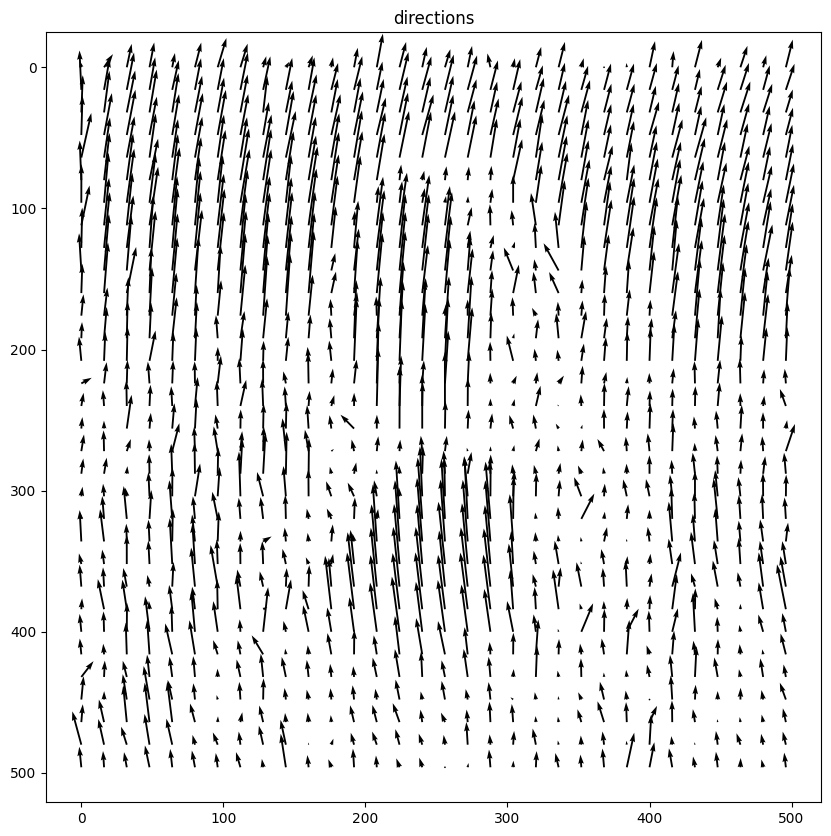

In [87]:
import matplotlib.pyplot as plt


def plot_arrows(tensor, title, spacing=8, scale=1):
    n = tensor.shape[0]
    X, Y = np.meshgrid(np.arange(0, n, spacing), np.arange(0, n, spacing))
    U = tensor[::spacing, ::spacing, 0].detach().cpu().numpy()
    V = tensor[::spacing, ::spacing, 1].detach().cpu().numpy()

    plt.figure(figsize=(10, 10))
    plt.quiver(X, Y, U, V, scale_units='xy', scale=scale)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()


directions = torch.rot90( field.field[:, :, 0, :2] )
plot_arrows(directions, "directions", spacing=16, scale=0.1)
